In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math 
import scipy.optimize, scipy.stats
import pandas as pd
from utils import *
from matplotlib import cm


    
def andersen(T, K, ind, param, iv, price, smooth = True):
    deltaT, deltaK = T[ind+1] - T[ind], K[2] - K[1]
    """
        we need to create the values Z 
        Z will be a vector with the same length of K minus 2 value
        function to fill the vol starting from the value that we give in input in param
    """
    if smooth: 
            pc_vol = fill_piecewise_int(iv[:,ind], param)
    else:
            pc_vol = fill_piecewise(iv[:,ind], param)
            
    z =  zeta(deltaK, deltaT, pc_vol[1:-1])
    """create the A matrix"""
    
    A = np.diag( np.r_[1, 1+2*z,1])
    A = A + np.diag(np.r_[-z,0], -1) + np.diag(np.r_[0,-z], 1)
    """ price at T """
    C = price[:,ind]
    """ estimation of the price at T+1 """
    C_t_plus_one = np.linalg.solve(A , C )
    
    return C_t_plus_one




def get_callprice(smooth = False):
    """ here we define the matrix of the prices of the call we will have to fill """ 
    C = np.zeros((len(K), len(T))) 
    """ setting the price of maturity equal to 0 """
    C[:,0] = np.maximum( s0 - K, 0 )
    
    """ we can also compute the price for the value that we have the volatility """
    row_notzerovol, col_notzerovol = np.where( iv != 0 )
    for row, col  in zip(row_notzerovol, col_notzerovol):
        C[row, col+1] = black_scholes_call(0, T[1+col], s0, K[row], 0, iv[row, col], q = 0)
    
    

    val = []
    for i in range(len(T) - 1):
        """
            check where the implied volatility is not equal to 0 at T+1
            in these point we have the prices of the call option
        """
        n = np.where(iv[:,i]!=0)[0]
        """ define initial values to use of theta"""
        init = 0.35*s0*np.ones(len(n))
        """
            we want to minimize the function, but obvioulsy only in the point for which we have an observation of
            the call price at T+1
            remember that we add 0 to T, and therefore iv[:,i] corresponds to iv at T+1
            therefore for the point for which we have an implied vol a T+1 we try to match the price T+1 obtained from the model
            with the prices that we have at T+1
        """
        fun = lambda par : ((iv[:,i]!=0) * np.power((andersen(T, K, i, par , iv, C, smooth) - C[:,i+1]),2)).sum()
        b = [(0,100000) for j in init]
        minim  = scipy.optimize.minimize(fun, init, bounds = b)
        print(f"Step:{i}    Optimization Fun Value: {np.round(minim.fun, )}  ")
        values = minim.x
        val.append(values)
        C[:,i+1] = andersen(T, K, i, values , iv, C, smooth)
    
    return C, dict(zip(T, val))

In [2]:
""" let's first read the data """ 
df = pd.read_excel("SX5E_Impliedvols.xlsx", header = 0)
T = np.array([0] + [j for j in df.columns[2:]])
K = df.iloc[:,1].to_numpy()
iv = df.iloc[:,2:].to_numpy()
df = df.iloc[:,2:]
df = df.set_index(np.round(K, 4))

T_later = [1, 1.5]
S0 = 2772.70
s0 = 1
K = K * s0
   
    
C_smooth, theta = get_callprice(smooth = "linReg")  
    




Step:0    Optimization Fun Value: 0.0  
Step:1    Optimization Fun Value: 0.0  
Step:2    Optimization Fun Value: 0.0  
Step:3    Optimization Fun Value: 0.0  
Step:4    Optimization Fun Value: 0.0  
Step:5    Optimization Fun Value: 0.0  
Step:6    Optimization Fun Value: 0.0  


In [3]:
"""
now we need to find the implied volatility for the each point on the grid 
implied_vol(PriceCall, t, T, S, K, r, start, method = "newton", precision = 10**(-5.5))
"""
iv_ = np.empty((len(K), len(T)-1))
for row, k in enumerate(K):
    for col, T_ in enumerate(T[1:]):
        iv_[row,col], prec = implied_vol(C_smooth[row,col+1], 0, T_, s0, k, r = 0, start = 0.2, method = "halleys", precision = 10**(-5))
        if prec >= 0.1:
            print("Low Precision", prec)

            
"""
    Implied Volatility 
"""            
print(iv_)

[[0.79962842 0.40818639 0.29514304 ... 0.18371552 0.15429867 0.10238653]
 [1.02310541 0.61759505 0.50701359 ... 0.41036853 0.36791901 0.28925023]
 [1.01847676 0.62048395 0.5137625  ... 0.42592006 0.385556   0.31023644]
 ...
 [0.58688188 0.29570279 0.22464157 ... 0.18448363 0.15999449 0.1561997 ]
 [0.58366297 0.29399001 0.22299456 ... 0.18141335 0.15696348 0.14962845]
 [0.16168535 0.08053579 0.05765671 ... 0.03530453 0.02906715 0.01919079]]


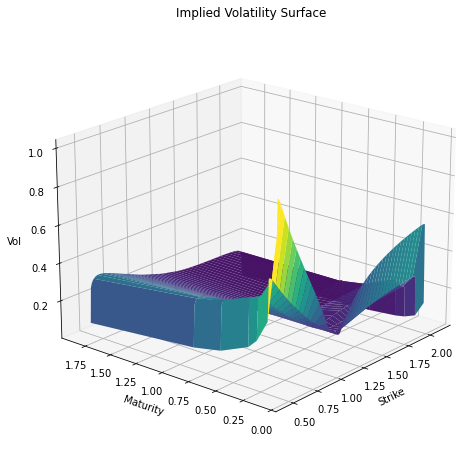

In [4]:
""" if there are some NA we set them to 0 """ 
iv[np.isnan(iv)]  = 0    
x, y = np.meshgrid(K, T[1:], indexing = "ij" )
z = iv_

fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = '3d')
ax.view_init(20, 40)
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
ax.set_title("Implied Volatility Surface")
ax.set_zlabel("Vol")
ax.set_xlim(K.max()*1.1,K.min()*0.90)
ax.set_ylim(T.max()*1.1, T.min()*0.9)
surf = ax.plot_surface(x, y, z, cmap=cm.viridis,
                       linewidth=1, antialiased=True)


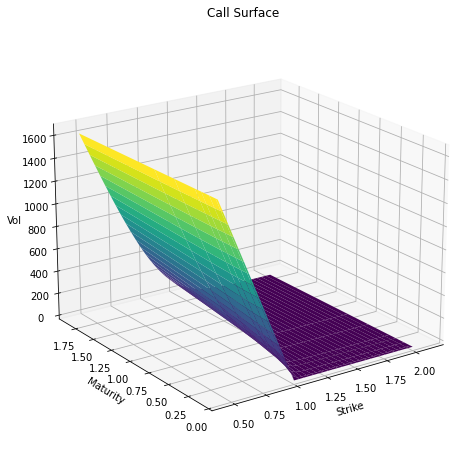

In [5]:
x, y = np.meshgrid(K, T[:], indexing = "ij" )
z = C_smooth * S0/s0

#we can also visualize the price 
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = '3d')
ax.view_init(20, 55)
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
ax.set_title("Call Surface")
ax.set_zlabel("Vol")
ax.set_xlim(K.max()*1.1,K.min()*0.90)
ax.set_ylim(T.max()*1.1, T.min()*0.9)
surf = ax.plot_surface(x, y, z, cmap=cm.viridis,
                       linewidth=1, antialiased=True)

In [6]:
""" 
    Extrapolation of the price for T = 1 and T = 1.5 
"""

T = np.array(T)
price_call_extra = []
for t in T_later:
    """ get the t for which we habe the price closer to the desired date """
    t_ref = T[t>T][-1]
    T_list = [t_ref, t]
    index_t_ref = np.where(T ==t_ref)[0][0]
    price_call_extra.append(andersen(T_list, K, 0, theta[t_ref] , iv[:,index_t_ref:], C_smooth, False))


"""
    extrapolation of the implied vol for T = 1, 1.5 
"""

iv_extra = np.empty((len(K), 2))
for row, k in enumerate(K):
    for col, T_ in enumerate(T_later):
        iv_extra[row,col], prec = implied_vol(price_call_extra[col][row], 0, T_, s0, k, r = 0, start = 0.2, method = "halleys", precision = 10**(-4))
        if prec >= 0.1:
            print("Low Precision", prec)

iv_ext = pd.DataFrame(iv_extra, index = K, columns = [f"T = {T_}" for T_ in T_later])
iv_ext.index.name = "K"
iv_ext

T = 1   T = 1.5
K                       
0.40  0.120640  0.107686
0.41  0.260506  0.271324
0.42  0.266965  0.285254
0.43  0.268594  0.292019
0.44  0.268150  0.295515
...        ...       ...
1.96  0.138123  0.154660
1.97  0.137493  0.152791
1.98  0.136348  0.149969
1.99  0.133957  0.144966
2.00  0.028763  0.025108

[161 rows x 2 columns]

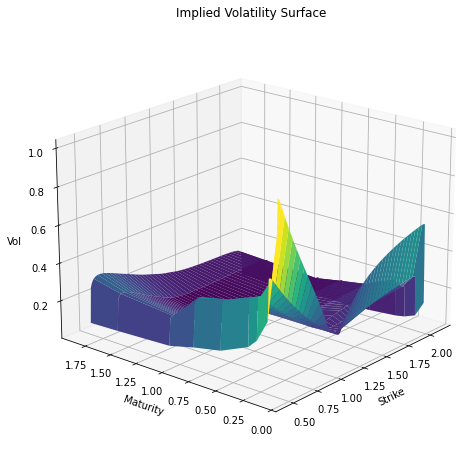

In [7]:
"""
    plotting the surface with the values obtained with extrapolation at the previous point 
"""


iv_complete = np.c_[iv_[:,:-1],iv_extra,iv_[:,-1]]
iv_complete[np.isnan(iv_complete)]  = 0    
x, y = np.meshgrid(K, np.sort(np.r_[T  ,T_later])[1:], indexing = "ij" )
z = iv_complete

fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection = '3d')
ax.view_init(20, 40)
ax.set_xlabel("Strike")
ax.set_ylabel("Maturity")
ax.set_title("Implied Volatility Surface")
ax.set_zlabel("Vol")
ax.set_xlim(K.max()*1.1,K.min()*0.90)
ax.set_ylim(T.max()*1.1, T.min()*0.9)
surf = ax.plot_surface(x, y, z, cmap=cm.viridis,
                       linewidth=1, antialiased=True)
